# Wavelet estimation for well ties

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from bruges.filters import ricker, rotate_phase
from scipy import linalg as la
from numpy.linalg import lstsq

from sklearn import linear_model
%matplotlib inline

/Users/Evan/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


We'll need a function to normalize a seismic trace.

In [2]:
def norm(data):
    return data/np.amax(data)

# Read in the data

In [3]:
r = np.load("rpp.npy")
s = np.load("seismic.npy")
dt = .002
t = np.arange(s.size) * dt

Plot the reflectivity and the seismic trace side by side.

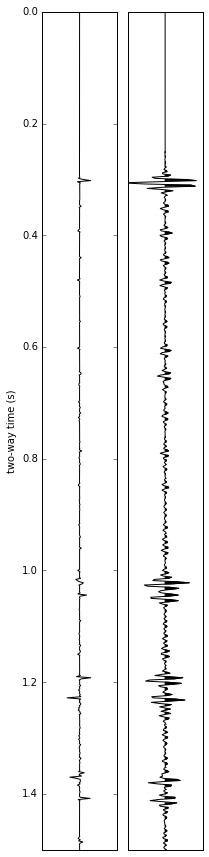

In [4]:
plt.figure(figsize=(3,12))
# Reflectivity track
plt.subplot(121)
plt.plot(r, t, 'k')
plt.xticks([])
plt.xlim(-1,1)
plt.xticks([])
plt.ylim(1.5,0)
plt.ylabel('two-way time (s)')

# Seismic track
plt.subplot(122)
plt.plot(s, t, 'k')
plt.fill_betweenx(t, s, 0,
                  s > 0, color='k', alpha=1.0)
plt.ylim(1.5,0)
plt.xlim(-0.1,0.1)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

Compute the spectrum of the seismic trace.

In [5]:
Ss = np.abs(np.fft.fft(s))
faxis = np.fft.fftfreq(len(s), d=dt)
Y = np.log10(Ss[0:len(faxis)//2]) 
X = faxis[:len(faxis)//2]

Make a plot with a Ormsby Bandpass filter

In [6]:
freqs = [5,80,130,160]
c = 1.0
p = c*np.array([-2.5,-0.1,-0.1,-2.5])

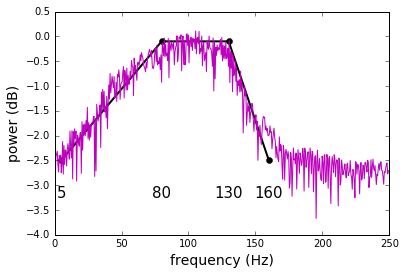

In [7]:
plt.plot(X,Y,'m')
plt.plot(freqs, p, 'ko-', lw=2, zorder=0, ms=6)
for f in freqs:
    plt.text(f,1.20*p[0],f, ha='center', va='top', fontsize=15)
plt.xlabel('frequency (Hz)', fontsize=14)
plt.ylabel('power (dB)', fontsize=14)

### Make an ormsby wavelet

In [8]:
from bruges.filters.wavelets import ormsby, ricker

Bruges has a function for creating an Ormsby wavelet. We need to pass in the the duration, the sample rate and the four bandpass frequencies as a list.

In [9]:
duration = 0.256 # seconds
# Ormsby
orms = ormsby(duration, dt=0.002, f=freqs)
tw = np.arange(-len(orms)//2,len(orms)//2,1)*dt

Let's plot the Ormsby wavelet in the time domain.

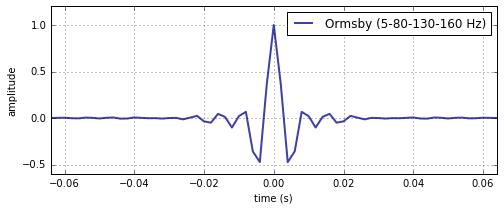

In [11]:
fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet
plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
plt.legend(loc=1)
plt.xlim(-0.064,0.064)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.grid()

# Wavelet estimation by autocorrelation

If we assume the earth’s reflectivity spectrum to be flat, then the shape of the spectra can be attributed to the shape of the wavelet. By doing an autocorrelation of the trace, that is, correlating the trace with itself, we get a zero-phase signal from the amplitude spectrum of the trace.

In [13]:
dw = 64 # number of samples to display on either side of zero
acorr = np.correlate(s, s, mode='same')
w1 = acorr[len(s)//2-dw//2:len(s)//2+dw//2]

Let's compare the autocorrleation of the trace with the Ormsby wavelet that we just made.

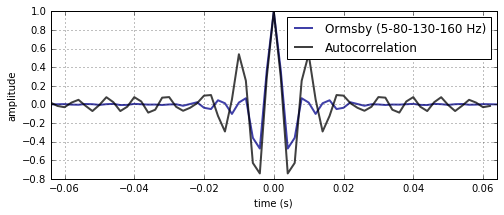

In [14]:
fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet
plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.75, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
plt.plot(np.arange(0,len(w1))*dt-0.064, norm(w1), 'k', lw=2, alpha=0.75,
         label='Autocorrelation')
plt.legend(loc=1)
plt.xlim(-0.064,0.064)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
plt.grid()

# Wavelet estimation by spectral division

Let's write a function for doing spectral division. 

In [15]:
def spectral_division(reflectivity, data):
    
    seis_fft = np.fft.fft(data)
    ref_fft = np.fft.fft(reflectivity)

    wavelet_spec = seis_fft / ref_fft
    wavelet_div = np.fft.ifft(wavelet_spec)
    
    return wavelet_div
    

Now let's make a plot of this signal obtained by doing spectral division.

/Users/Evan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 0.256)

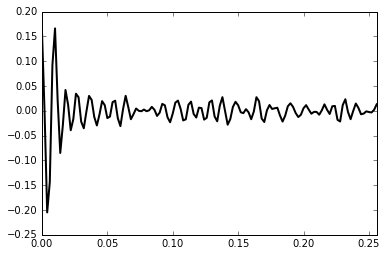

In [16]:
spec_div = spectral_division(r, s)
plt.figure()
plt.plot(t, spec_div, 'k', lw=2)
plt.xlim([0,0.256])

Notice how it has some high energy values at the start but then reverberates, and has noise for a long time. Alternately, lets try to the naive solution via least squares.

In [17]:
def wigner(rpp, seismic):
    opConvolve = la.toeplitz(rpp)
    wavelet = lstsq(opConvolve, seismic)[0]
    return wavelet     

(-1, 1)

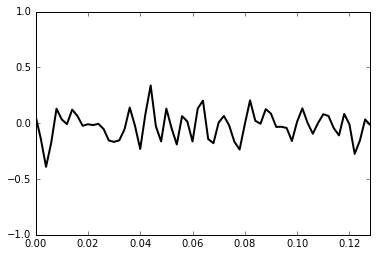

In [18]:
wigner_wave = wigner(r, s)
plt.plot(t, wigner_wave, 'k', lw=2)
plt.xlim([0,0.128])
plt.ylim([-1,1])

Both methods don't return meaningful or useful wavelets, which basically shows that migrated seismic does not adhere to a convolutional model. Let's check the Spectra

(-4, 0)

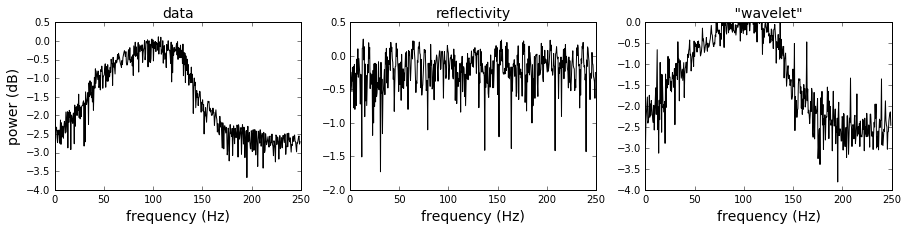

In [19]:
Y1 = np.log10(np.abs(np.fft.fft(s))[0:len(faxis)//2]) 
R1 = np.log10(np.abs(np.fft.fft(r))[0:len(faxis)//2]) 
W1 = np.log10(np.abs(np.abs(np.fft.fft(s) / np.fft.fft(r)))[0:len(faxis)//2]) 
W2 = np.log10(np.fft.fft(wigner_wave)[0:len(faxis)//2]) 


fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(131)

ax.plot(X,Y1, 'k', lw=1)
ax.set_title('data', fontsize=14)
ax.set_ylabel('power (dB)', fontsize=14)
ax.set_xlabel('frequency (Hz)', fontsize=14)

ax2 = fig.add_subplot(132)
ax2.plot(X,R1, 'k', lw=1)
ax2.set_title('reflectivity', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

ax3 = fig.add_subplot(133)
ax3.plot(X,W1, 'k', lw=1)
# ax3.plot(X,W2, 'dark blue', lw=1)
ax3.set_title(' "wavelet" ', fontsize=14)
ax3.set_xlabel('frequency (Hz)', fontsize=14)
ax3.set_ylim(-4,0)

The spectrum of the wavelet is not ideal. It has tons of noise, even though it has the same basic shape as the data. 

Let's use some optimization tricks. Regularize the least squares problem and bias it towards an answer we want. Start with something simple, like an L2 norm. Basically we know a priori that we don't want ton of large spikes in our wavelet and an L2 norm will penalize these. Note ridge regression is just least-squares with an L2 penalty.

# Wavelet estimation by least squares

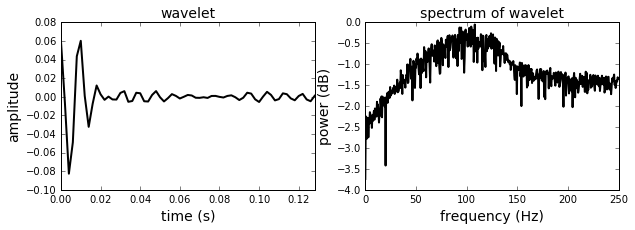

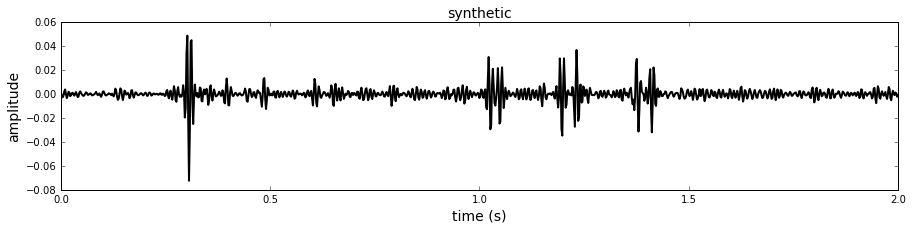

In [21]:
clf = linear_model.Ridge(alpha = 0.5, fit_intercept=False)
R = la.toeplitz(r)
clf.fit(R, s)
wavelet = clf.coef_

Y2 = np.log10(np.abs(np.fft.fft(wavelet))[0:len(faxis)//2])  

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(121)
ax.plot(t, wavelet, 'k', lw=2)
ax.set_xlim([0,0.128])
ax.set_title('wavelet', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

# Check the spectra
ax2 = fig.add_subplot(122)
ax2.plot(X,Y2, 'k', lw=2)
ax2.set_title('spectrum of wavelet', fontsize=14)
ax2.set_ylabel('power (dB)', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

# modelled seismic
plt.figure(figsize=(15,3))
plt.plot(t, np.dot(R, wavelet), 'k', lw=2)
plt.title('synthetic', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.xlabel('time (s)', fontsize=14)

Hey, not bad. Looks more like wavelet! The spectra has way less variance, but doing the regularization added some noise synthetic; so it's not as good as a match to the real data. Such is life, when our model is wrong we always trade off between fitting the data and seeing what we want to see. 

Let's try some other tricks. We know the approximate length of the wavelet, and it definitely won't be two seconds long. Let's add a projection operator into the mix which forces all the wavelet energy to be in the first few samples.

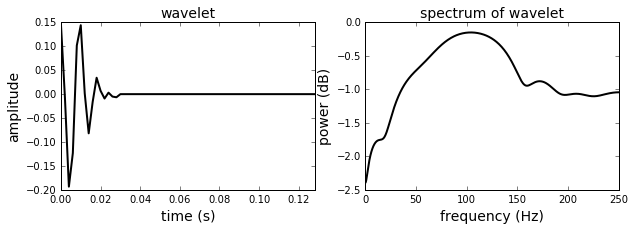

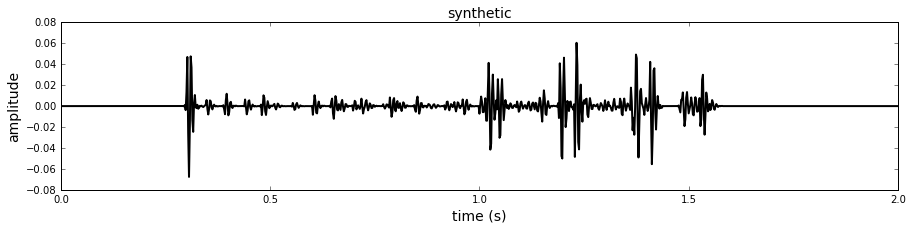

In [23]:
wavelet_size = 15 # samples
opProj = np.zeros((r.size, r.size))
opProj[:wavelet_size, :wavelet_size] = np.eye(wavelet_size)

op  = np.dot(R, opProj)
wavelet = lstsq(op, s)[0]

Y3 = np.log10(np.abs(np.fft.fft(wavelet))[0:len(faxis)//2])  

fig = plt.figure(figsize = (10,3))
ax = fig.add_subplot(121)
ax.plot(t, wavelet, 'k', lw=2)
ax.set_xlim([0,0.128])
ax.set_title('wavelet', fontsize=14)
ax.set_ylabel('amplitude', fontsize=14)
ax.set_xlabel('time (s)', fontsize=14)

# Check the spectra
ax2 = fig.add_subplot(122)
ax2.plot(X,Y3, 'k', lw=2)
ax2.set_title('spectrum of wavelet', fontsize=14)
ax2.set_ylabel('power (dB)', fontsize=14)
ax2.set_xlabel('frequency (Hz)', fontsize=14)

# modelled seismic
plt.figure(figsize=(15,3))
plt.plot(t, np.dot(R, wavelet), 'k', lw=2)
plt.title('synthetic', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.xlabel('time (s)', fontsize=14)

Take home: the basic convolution model can't fit the data. There are multiples, processing issues, and migrations effects that aren't accounted. Because the model is wrong we are going to get a wrong answer, so we use regularization and other optimization tricks so we at least get a wrong answer that looks legit. 

Something else to think about:  this is synthetic data, and things are already messy and uncertain for even the simplest inversion. Things are obviously going to be total non-sense on real data. More complicated inversions like Shuey-terms, FWI, least-squares RTM... get real ;).

# Create synthetics

In [24]:
synth = np.dot(op, wavelet)

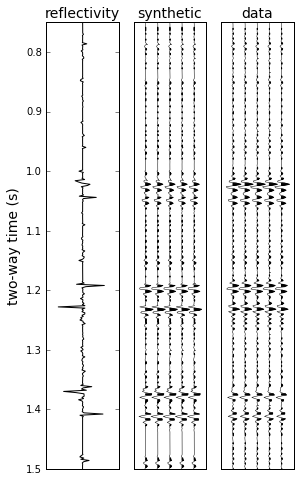

In [25]:
# Params
ylim = (0.75, 1.5)
# N wiggles
nwigs = 5
gap = 0.1

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)

# Reflectivity track
ax1.plot(r, t, 'k')
ax1.set_xticks([])
ax1.set_xlim(-0.5,0.5)
ax1.set_xticks([])
ax1.set_xlabel('reflectivity', fontsize=14)
ax1.xaxis.set_label_position('top') 
ax1.set_ylim(ylim[1],ylim[0])
ax1.set_ylabel('two-way time (s)', fontsize=14)

# Synthetic track
for i in range(nwigs):
    ax2.plot(synth+i*gap, t, 'k', lw=0.5)
    ax2.fill_betweenx(t, synth+i*gap, i*gap,
                      synth+i*gap > i*gap, color='k', alpha=1.0)
ax2.set_xlim(-gap,gap*(nwigs))
ax2.set_ylim(ylim[1],ylim[0])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('synthetic', fontsize=14)
ax2.xaxis.set_label_position('top') 


# Seismic track
for i in range(nwigs):
    ax3.plot(s+i*gap, t, 'k', lw=0.5)
    ax3.fill_betweenx(t, s+i*gap, i*gap,
                      s+i*gap > i*gap, color='k', alpha=1.0)
ax3.set_xlim(-gap,gap*(nwigs))
ax3.set_ylim(ylim[1],ylim[0])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('data', fontsize=14)
ax3.xaxis.set_label_position('top') 

# Wavelet track
if False:
    ax4 = fig.add_subplot(144)
    ax4.plot(wavelet, t, 'k', lw=0.5)
    ax4.fill_betweenx(t, wavelet, 0,
                      wavelet > 0, color='k', alpha=1.0)
    ax4.set_ylim(ylim[1],ylim[0])
    ax4.set_xlim(-0.1,0.1)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.tight_layout()

Finally, we can compute the correlation coefficient between the synthetic and the data.

In [26]:
np.corrcoef(s,synth)[0][1]

0.81788648323700142

We can plot the autocorrelation of the wavelet to show its zero phase version to compare with the other zero phase wavelets

/Users/Evan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


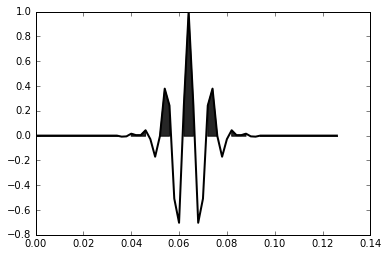

In [27]:
wzeroph = norm(np.correlate(norm(wavelet), norm(wavelet), mode='same'))
dw = 64
wshort = wzeroph[len(wzeroph)//2-dw/2:len(wzeroph)//2+dw/2]
tshort = np.arange(0,len(wshort),1)*dt
plt.plot(tshort, wshort,'k', lw=2)
plt.fill_between(tshort, wshort, -0.005,
                      wshort > -0.005, color='k', alpha=0.85)

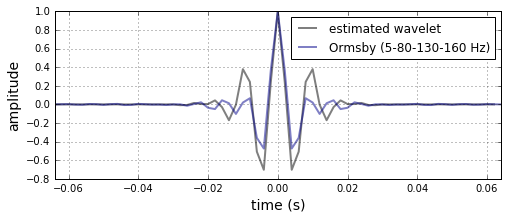

In [28]:
fig =plt.figure(figsize=(8,3))
# plot Ormsby wavelet

plt.plot(tshort-0.064, wshort,'k', lw=2, alpha=0.5, label='estimated wavelet')

plt.plot(tw, orms, 'darkblue', lw=2, alpha=0.5, 
         label='Ormsby (%i-%i-%i-%i Hz)' %(freqs[0],freqs[1],freqs[2],freqs[3]))
plt.legend(loc=1)
plt.xlim(-0.064,0.064)
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('amplitude', fontsize=14)
plt.grid()

In [29]:
synth = np.convolve(norm(wzeroph),r,mode='same')

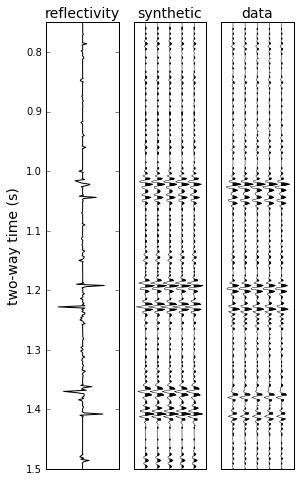

In [30]:
# Params
ylim = (0.75, 1.5)
# N wiggles
nwigs = 5
gap = 0.1
g = 0.25  # gain

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)

# Reflectivity track
ax1.plot(r, t, 'k')
ax1.set_xticks([])
ax1.set_xlim(-0.5,0.5)
ax1.set_xticks([])
ax1.set_xlabel('reflectivity', fontsize=14)
ax1.xaxis.set_label_position('top') 
ax1.set_ylim(ylim[1],ylim[0])
ax1.set_ylabel('two-way time (s)', fontsize=14)

# Synthetic track
for i in range(nwigs):
    ax2.plot(g*synth+i*gap, t, 'k', lw=0.5)
    ax2.fill_betweenx(t, g*synth+i*gap, i*gap,
                      g*synth+i*gap > i*gap, color='k', alpha=1.0)
ax2.set_xlim(-gap,gap*(nwigs))
ax2.set_ylim(ylim[1],ylim[0])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('synthetic', fontsize=14)
ax2.xaxis.set_label_position('top') 


# Seismic track
for i in range(nwigs):
    ax3.plot(s+i*gap, t, 'k', lw=0.5)
    ax3.fill_betweenx(t, s+i*gap, i*gap,
                      s+i*gap > i*gap, color='k', alpha=1.0)
ax3.set_xlim(-gap,gap*(nwigs))
ax3.set_ylim(ylim[1],ylim[0])
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('data', fontsize=14)
ax3.xaxis.set_label_position('top') 

# Wavelet track
if False:
    ax4 = fig.add_subplot(144)
    ax4.plot(wavelet, t, 'k', lw=0.5)
    ax4.fill_betweenx(t, wavelet, 0,
                      wavelet > 0, color='k', alpha=1.0)
    ax4.set_ylim(ylim[1],ylim[0])
    ax4.set_xlim(-0.1,0.1)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.tight_layout()

In [31]:
np.corrcoef(s,synth)[0][1]

0.72822889666191759